# Gas CART

## Import and load

In [4]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.evaluator import evaluator

import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import prince
import numpy as np

import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix


### Load GAS type cars

In [ ]:
data = Loader.load_by_fueltype("Gas")
label_encoder = LabelEncoder()

In [87]:
data["price_categ"].value_counts()

price_categ
Middle low range    509
Budget              480
Low end             250
Middle range         31
Alto                 17
Name: count, dtype: int64

In [88]:
data['price_categ'] = data['price_categ'].replace({ # Combinar clases similares
    'Luxury': 'Alto',
    'Premiun': 'Alto',
    'High end': 'Alto',
    'Middle high range': 'Alto',
})

data = data[data['price_categ'] != 'Very low end'] # Eliminar la clase 'Very low end'
data['price_categ'] = data['price_categ'].str.strip()

# Revisa la nueva distribución
data['price_categ'].value_counts()

price_categ
Middle low range    509
Budget              480
Low end             250
Middle range         31
Alto                 17
Name: count, dtype: int64

In [90]:
# Ajustar y transformar la columna price_categ
data['price_categ'] = label_encoder.fit_transform(data['price_categ'])
data['price_categ'].value_counts()

price_categ
3    509
1    480
2    250
4     31
0     17
Name: count, dtype: int64

#### We can see the data is hightly unbalance and needs treatment before reating the tree model 

Aproach 1

1. Random Over-Sampling
This method duplicates instances of the minority class randomly until both classes are balanced. This is a simpler approach than SMOTE and doesn’t create synthetic data, so it avoids potential issues with noise.

###### Pros: Quick and straightforward; retains original data.
###### Cons: May lead to overfitting, especially if the dataset is small

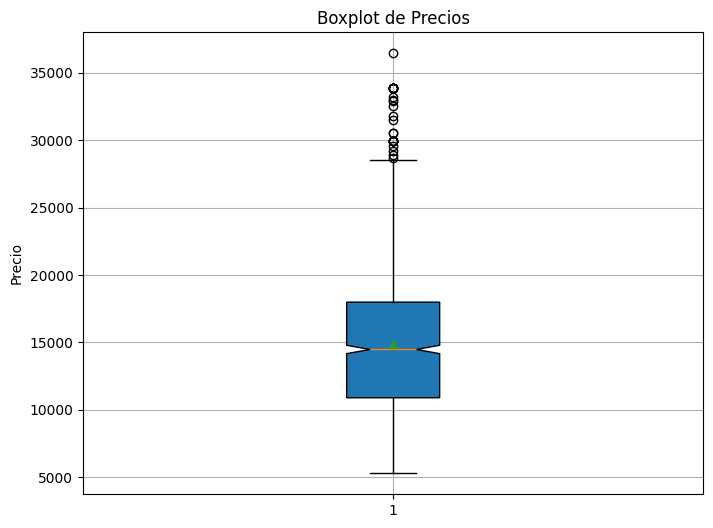

In [91]:
precios_electricos = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_electricos, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

The outliers were checked manually throught the data source, and we could confirmed that they are not outliers

In [92]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)  # Esta es la mediana
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)

28625.0


,price,brand
idx,,
48483,36441,DFSK
40872,33900,EVO
43076,33900,EVO
91054,33900,EVO
24917,33900,EVO
85825,33900,EVO
37736,33900,EVO
43137,33900,EVO
34644,33899,PIAGGIO


### Gas , Numerical variables selection

In [93]:
def fill_gas_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    #fill the elemental columns that has a minor amount of missing data with the mode
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.length")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.height")

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")

    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_gas_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])
    numerical_columns.drop(columns=[ "car_id"], inplace=True)

    #if all the values of the numerical columns is 0, we remove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)

    #Remove the column with all NAs
    max_nans = 6586
    thresh = numerical_columns.shape[0] - max_nans

    numerical_columns.dropna(axis=1, thresh=thresh+1, inplace=True)
    return fill_gas_numerical_columns(numerical_columns)

In [94]:
numerical_columns = get_gas_numerical_columns(data)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.9674673980367807%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 15.456430834096604%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 5.050674953115149%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 4.822246491513311%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 3.4546319076731025%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 9.788386626797587%


In [95]:
correlation_matrix = numerical_columns.corr()["price"]
print(correlation_matrix)

price                    1.000000
km                      -0.666253
year                     0.630371
cubicCapacity            0.134931
doors                    0.196730
seatingCapacity          0.262632
trunkCapacityInLiters    0.200050
maxSpeed                 0.029122
acceleration            -0.190765
power_cv                 0.438754
power_kw                 0.444135
max_torque_nm            0.351313
speakers                 0.187856
dimensions.width         0.315454
dimensions.height        0.161946
dimensions.length        0.305562
Numero_Testigos          0.010558
displacement_liters      0.132262
displacement_cc          0.171891
number_of_cylinders     -0.147125
compression_ratio       -0.511080
Llantas_Diametro_cm      0.512251
price_categ              0.495647
Name: price, dtype: float64


In [96]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

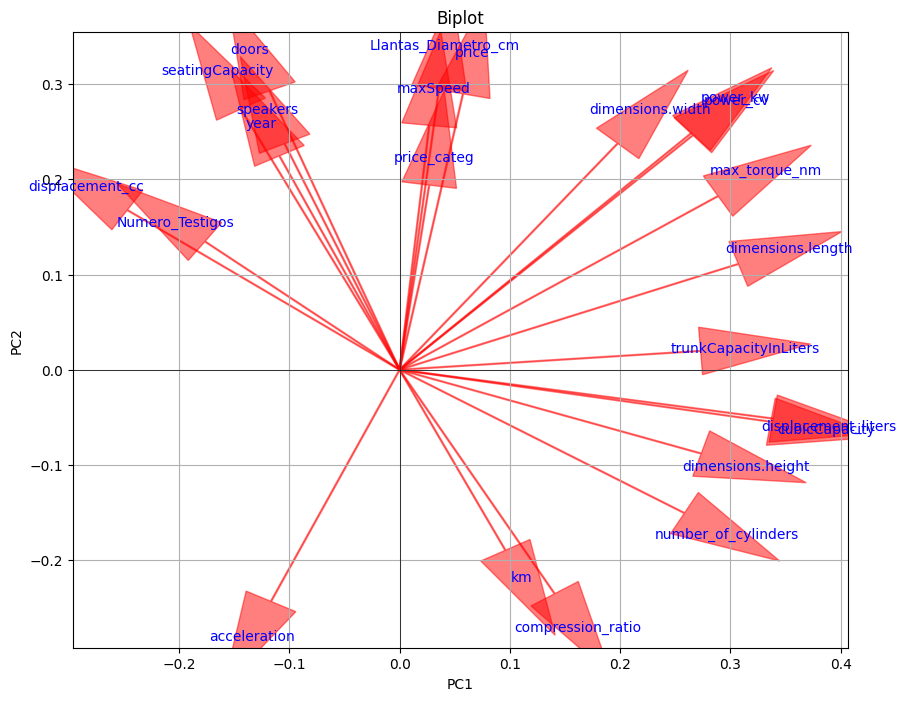

In [97]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

## CART regression with only numerical values

- Using only numerical values we can use the SMOTE technique to generate synthetic value data and rebalance our unbalance dataset.

### TEST 1 - SMOTE

In [114]:
X = numerical_columns.drop(columns=["price_categ","price"]) # + price_categ
y = numerical_columns["price_categ"]

In [115]:
# Train-Test Split Before Applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Training the CART Model (Decision Tree) on Resampled Data

In [117]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [118]:
y_pred = clf.predict(X_test)

# Cell 7: Evaluate the Model
# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.83      0.84      0.83        91
           2       0.71      0.78      0.74        45
           3       0.96      0.90      0.93       115
           4       0.29      0.40      0.33         5

    accuracy                           0.84       258
   macro avg       0.62      0.68      0.65       258
weighted avg       0.85      0.84      0.85       258

Confusion Matrix:
 [[  1   0   0   0   1]
 [  0  76  12   3   0]
 [  0  10  35   0   0]
 [  0   6   2 103   4]
 [  2   0   0   1   2]]
